## ℹ️ A/B test

Компания разработала новую веб-страницу, чтобы увеличить конверсию в покупку.

Цель — помочь бизнесу принять решение на основе данных: раскатить на 100% новую страницу или оставить старую.

## 📊Результаты

- Проверка двухсторонней гипотезы с использованием Z-теста показала отсутствие статистически значимой разницы в конверсии между новой и старой страницами.
- Рекомендуется оценить влияние новой страницы на дополнительные метрики. В качестве отправной точки целесообразно посмотреть, как изменилась средняя выручка на пользователя (ARPU).
- Несмотря на отсутствие статистически значимой разницы в конверсии, окончательное решение должно учитывать также внешние факторы: и потраченные ресурсы на разработку, и контекст самого редизайна, конкурентов и прочее.

| Параметр               | Контрольная группа | Тестовая группа | Разница    |
|:-----------------------|:------------------:|:---------------:|:----------:|
| Конверсия              | 12.04%             | 11.88%          | -0.0016    |
| Относительное изменение| -                  | -               | -1.31%     |
| P-value                | -                  | -               | 0.19       |
| Доверительный интервал | [0.119, 0.122]     | [0.117, 0.120]  | -          |

## 📋 Навигация
- [Загрузка и обзор данных](#overview)
- [Предобработка данных и EDA](#processing)
- [Подведение итогов A/B-теста](#ab)
- [Выводы и рекомендации](#results)

<h2 id="overview">Загрузка и обзор данных</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import statsmodels.stats.api as sms

In [ ]:
# Прочитаем файл с данными
try:
    df = pd.read_csv('..ab_test.csv')
except Exception as e:
    print(f"Ошибка: {e}")
    
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# Переименуем колонки
df.columns = ['user_id','timestamp','group','page','converted']
df.head()

,user_id,timestamp,group,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
print(f'Количество строк: {len(df)}')
print(f'Количество уникальных пользователей: {df['user_id'].nunique()}')

Количество строк: 294478
Количество уникальных пользователей: 290584


**В датасете могут быть ошибки или дубликаты, это проверим на этапе &laquo;Предобработки данных и EDA&raquo;**

In [5]:
# Общая инфа по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  int64 
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
# Посмотрим пропуски
df.isnull().sum()

user_id      0
timestamp    0
group        0
page         0
converted    0
dtype: int64

<h2 id="processing">Предобработка данных и EDA</h2>

page       new_page  old_page
group                        
control        1928    145274
treatment    145310      1965


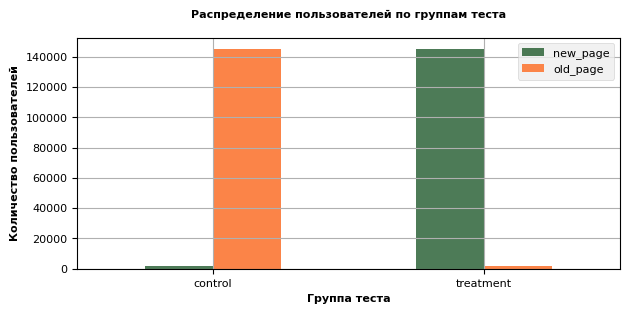

In [7]:
# Сводная таблица с количеством пользователей по группам и страницам
ab_pivot = df.pivot_table(index='group',columns='page',values='user_id',aggfunc='nunique')

print(ab_pivot)

# График распределения кол-ва юзеров в группах по страницам
ab_pivot\
    .plot(kind='bar',
          legend = True,
          grid=True,
          figsize = (7,3),
          fontsize=8,
          color=["#165323c3", "#fb8448"],
          rot = 0)

plt.style.use('bmh')
plt.title('Распределение пользователей по группам теста', fontsize=8, weight='extra bold', y=1.05)
plt.legend(fontsize=8)
plt.xlabel('Группа теста',fontsize=8, weight='extra bold')
plt.ylabel('Количество пользователей',fontsize=8, weight='extra bold')

plt.show()

**По графику видно, что в группы попали случайные пользователи. Их надо почистить.**

In [8]:
# Кол-во строк со случайными пользователями
mist_user = pd.concat([df[(df['group'] == 'control') & (df['page'] == 'new_page')], \
                      df[(df['group'] == 'treatment') & (df['page'] == 'old_page')]])

# Кол-во строк со случайными пользователями
mist_row = len(df[(df['group'] == 'control') & (df['page'] == 'new_page')])\
      + len(df[(df['group'] == 'treatment') & (df['page'] == 'old_page')])

print(f'Количество случайных пользователей: {mist_user['user_id'].nunique()}')
print(f'Доля случайных пользователей от общего количества: {mist_user['user_id'].nunique()/df['user_id'].nunique():.2%}')
print('=' * 55)
print(f'Количество ошибочных строк от общего количества: {mist_row}')
print(f'Доля ошибочных строк от общего количества: {mist_row/len(df):.2%}')

Количество случайных пользователей: 3893
Доля случайных пользователей от общего количества: 1.34%
Количество ошибочных строк от общего количества: 3893
Доля ошибочных строк от общего количества: 1.32%


In [9]:
print(f'Количество строк до очистки: {len(df)}')
print(f'Количество строк к удалению: {mist_row}')

# Очистим датасет от ошибок
df = df[(df['group'] == 'control') & (df['page'] == 'old_page')
         | (df['group'] == 'treatment') & (df['page'] == 'new_page')]

print(f'Проверка: количество оставшихся строк: {len(df)}')
print('=' * 55)
df.groupby(['group','page'], as_index=False).agg({'user_id':'count'})

Количество строк до очистки: 294478
Количество строк к удалению: 3893
Проверка: количество оставшихся строк: 290585


,group,page,user_id
0,control,old_page,145274
1,treatment,new_page,145311


**Теперь группы в датасете очищены от случайных пользователей**

In [10]:
# Функция проверки дубликатов
def duplicate_check(df):
    full_dup = df.duplicated().sum()
    id_dup = len(df[df['user_id'].duplicated(keep=False)])
    return {'full_dup': full_dup, 'id_dup': id_dup}

result = duplicate_check(df)
print(f"Количество полных дубликатов в датасете: {result['full_dup']}")
print(f"Количество дубликатов по user_id в датасете: {result['id_dup']}")

Количество полных дубликатов в датасете: 0
Количество дубликатов по user_id в датасете: 2


In [11]:
# Посмотрим дубликаты по user_id
df[df['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


**Пользователь с user_id - 773192 заходил на новую страницу несколько раз. Это не дубликат. Мы оставим первую запись, которая встречается с данным id в датасете.**

In [12]:
df = df.drop_duplicates(subset='user_id', keep='first')

result = duplicate_check(df)
print(f"Количество user_id, которые встречаются в датасете более 1 раза: {result['id_dup']}")

Количество user_id, которые встречаются в датасете более 1 раза: 0


group
treatment    145310
control      145274
Name: count, dtype: int64


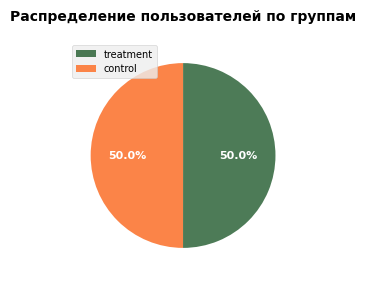

In [13]:
print(df['group'].value_counts())

# График распределения количества пользователей по группам
df['group'].value_counts(normalize=True)\
    .plot(kind='pie',
          figsize=(4,3),
          colors=["#165323c3", "#fb8448"],
          textprops={'color': 'white', 'fontsize': 8, 'weight':'bold'},
          autopct='%1.1f%%',
          startangle=90,
          counterclock=False) 

plt.style.use('bmh')
plt.title('Распределение пользователей по группам', fontsize=10, weight='bold', y=1.05)
plt.legend(fontsize=7)
plt.ylabel('')
plt.show()

<h2 id="ab">Подведение итогов A/B-теста</h2>

##### 🎯 Цели

- Определение метрики
- Определение требуемого размера выборки
- Определение статистического критерия
- Проведение A/B-теста
- Выводы

In [14]:
# Разобьем датасет на 2 группы
control, test = df.loc[df['group'] == 'control'], df.loc[df['group'] == 'treatment']

# Посмотрим конверсию и количество пользователей в контрольной группе и тестовой
conv_rate_a, conv_rate_b = control['converted'].mean(), test['converted'].mean()
converted_a, converted_b = len(control[control['converted'] == 1]),len(test[test['converted'] == 1])
visitors_a, visitors_b = len(control), len(test)


print(f"Количество пользователей в контрольной группе: {visitors_a}")
print(f"Количество пользователей в тестовой группе: {visitors_b}")
print('='*50)
print(f"Конверсия в контрольной группе: {conv_rate_a:.2%}")
print(f"Конверсия в тестовой группе: {conv_rate_b:.2%}")
print(f"Абслютная разница в конверсиях: {conv_rate_b - conv_rate_a:.2}")
print(f"Относительная разница в конверсиях: {(conv_rate_b - conv_rate_a) / conv_rate_a:.2%}")

Количество пользователей в контрольной группе: 145274
Количество пользователей в тестовой группе: 145310
Конверсия в контрольной группе: 12.04%
Конверсия в тестовой группе: 11.88%
Абслютная разница в конверсиях: -0.0016
Относительная разница в конверсиях: -1.31%


In [15]:
# Напишем функцию расчета размера выборки
def sample_size_calculator(baseline_rate, mde, power=0.8, alpha=0.05):
    
    # Расчет размера эффекта
    effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate * (1+mde)) # Расчет размера эффекта
    
    # Расчет необходимого размера выборки
    sample_size = sms.NormalIndPower().solve_power(
        effect_size,           # полученный размер эффекта
        alpha=alpha,           # уровень значимости
        power=power,           # желаемая мощность
        ratio=1                # соотношение размеров групп
    ) 
    return sample_size

baseline_rate = conv_rate_a  # конверсия в контрольной группе
mde = 0.0283 # минимальное значение, которое можем поймать

sample_size = sample_size_calculator(baseline_rate, mde)
print(f'Необходимый размер выборки для каждой группы: {sample_size:.0f}')

Необходимый размер выборки для каждой группы: 144950


#### 🔍 Формулировка гипотез для A/B-теста

**Нулевая гипотеза (H₀):**
- 📊 p₁ = p₂ 
- ❌ Отсутствуют различия конверсий между группами A и B

**Альтернативная гипотеза (H₁):**
- 📈 p₁ ≠ p₂
- ✅ Есть различия конверсий между группами A и B

In [16]:
# Напишем функцию для z-теста
def stat_check_z_test(converted_a, converted_b, visitors_a, visitors_b, alpha=0.05):
    
    # Коэффициенты конверсии
    p1, p2 = converted_a / visitors_a, converted_b / visitors_b

    # Стандартная ошибка для каждой конверсии
    se1, se2 = mth.sqrt(p1 * (1 - p1) / visitors_a), mth.sqrt(p2 * (1 - p2) / visitors_b)

    # Стандартная ошибка разницы между конверсиями
    se_diff = mth.sqrt(se1**2 + se2**2)

    # Разница в конверсии
    difference = p1 - p2
    absolute_difference = p2 - p1
    relative_difference = (p2 - p1)/p1

    # пропорция успехов в комбинированном датасете:
    p_combined = (converted_a + converted_b) / (visitors_a + visitors_b)

    # Z-статистика
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors_a + 1/visitors_b))

    # P-значение (двустороннее)
    p_value = 2 * (1 - st.norm.cdf(abs(z_value)))

    # Доверительный интервал
    z_critical = st.norm.ppf(1 - alpha/2)
    ci_group1, ci_group2 = (p1 - z_critical * se1, p1 + z_critical * se1), (p2 - z_critical * se2, p2 + z_critical * se2)
    
    # Доверительный интервал для разницы
    ci_diff = (difference - z_critical * se_diff, difference + z_critical * se_diff)

    print("РЕЗУЛЬТАТЫ A/B-ТЕСТА")
    print("=" * 22)
    print(f"Конверсия в контрольной группе: {converted_a}/{visitors_a} = {p1:.4f} ({p1:.2%})")
    print(f"Конверсия в тестовой группе: {converted_b}/{visitors_b} = {p2:.4f} ({p2:.2%})")
    print(f"Абсолютная разница: {absolute_difference:.4f} ({absolute_difference:.2})")
    print(f"Относительная разница: {round(relative_difference,4)} ({relative_difference:.2%})")
    print(f"z-statistic: {z_value:.3f}")
    print(f"p-value: {p_value:.2f}")

    print(f"\n95% Доверительный интервал для контрольной группы: [{ci_group1[0]:.3f}, {ci_group1[1]:.3f}]")
    print(f"95% Доверительный интервал для тестовой группы: [{ci_group2[0]:.3f}, {ci_group2[1]:.3f}]")
    print(f"95% Доверительный интервал для разницы: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")

    if p_value < alpha:
        print('\n✅ Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
        if difference > 0:
            print(f'📈 Конверсия тестовой группы значимо лучше на {difference:.1%}')
        else:
            print(f'📉 Конверсия тестовой группы значимо лучше на {abs(difference):.1%}')
    else:
        print('\n❌ Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными')

    return {
        'z_value': z_value,
        'p_value': p_value,
        'difference': difference,
        'ci_group1': ci_group1,
        'ci_group2': ci_group2,
        'ci_difference': ci_diff
    }

# Анализируем тест
result = stat_check_z_test(converted_a, converted_b, visitors_a, visitors_b)

РЕЗУЛЬТАТЫ A/B-ТЕСТА
Конверсия в контрольной группе: 17489/145274 = 0.1204 (12.04%)
Конверсия в тестовой группе: 17264/145310 = 0.1188 (11.88%)
Абсолютная разница: -0.0016 (-0.0016)
Относительная разница: -0.0131 (-1.31%)
z-statistic: 1.311
p-value: 0.19

95% Доверительный интервал для контрольной группы: [0.119, 0.122]
95% Доверительный интервал для тестовой группы: [0.117, 0.120]
95% Доверительный интервал для разницы: [-0.0008, 0.0039]

❌ Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


<h2 id="results">Выводы и рекомендации</h2>

**❌ Конверсия значимо не изменилась.**

*Рекомендуется оценить влияние новой страницы на дополнительные метрики. В качестве отправной точки целесообразно посмотреть, как изменилась средняя выручка на пользователя (ARPU).*

**Несмотря на отсутствие статистически значимой разницы в конверсии, окончательное решение должно учитывать также внешние факторы: и потраченные ресурсы на разработку, и контекст самого редизайна, конкурентов и прочее.**